<a href="https://colab.research.google.com/github/SmrithiCh/PRA3024-/blob/main/PRA3024_Gravitational_Waves_W2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install pycbc
! pip install -q 'gwpy==3.0.8'
! pip install matplotlib

# **Set 1**: Challenge 1

## Question 1: Loading Data & Data Duration + Sample Rate

In [4]:
#loading data into memory on pyCBC
from pycbc import frame
pycbc_strain = frame.read_frame('challenge1.gwf', 'H1:CHALLENGE1')

#loading data into memory on gwpy
from gwpy.timeseries import TimeSeries
gwpy_strain = TimeSeries.read('challenge1.gwf', channel="H1:CHALLENGE1")

In [5]:
print("Sample Rate:",pycbc_strain.get_sample_rate())
print("Duration:",pycbc_strain.get_duration())

Sample Rate: 4096.0
Duration: 128.0


## Question 2: Plotting Data in Time Domain

Text(0.5, 1.0, 'Data in Time-Domain')

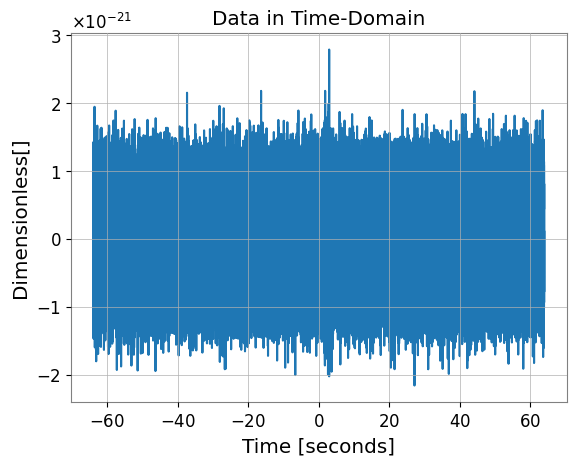

In [6]:
import matplotlib.pyplot as plt
plot = pycbc_strain.plot()
plt.xlabel('Time [seconds]')
plt.ylabel('Dimensionless[]')
plt.title('Data in Time-Domain')

## Question 3: Identifying the Signal

### Using Spectrograms

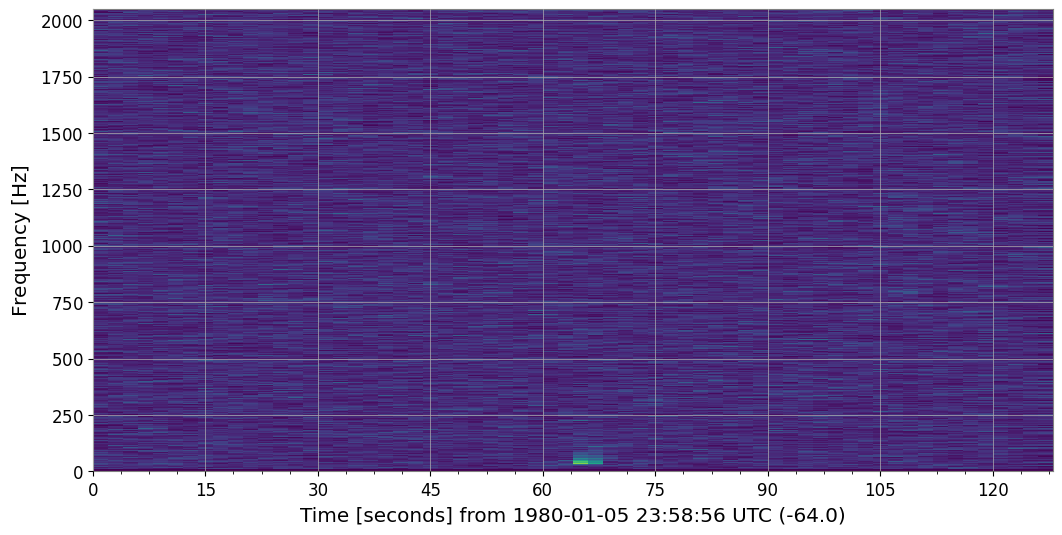

In [7]:
specgram = gwpy_strain.spectrogram2(fftlength=4, overlap=2, window='hann') ** (1/2.)
plot = specgram.plot()

#### There seems to be a signal between 63.75 and 67.5 seconds, but it's not very clear

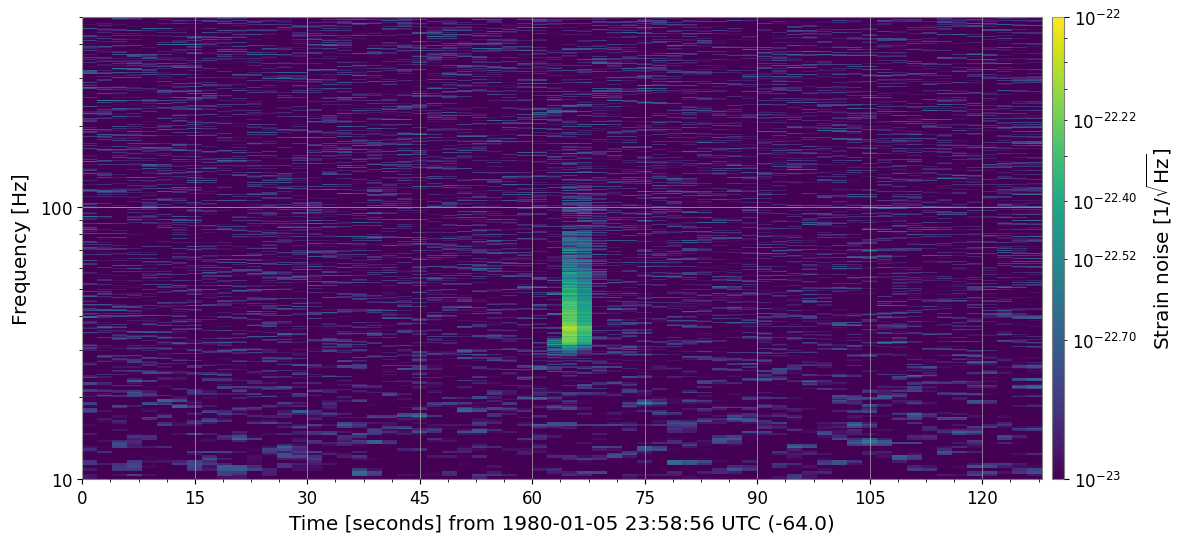

In [8]:
ax = plot.gca()
ax.set_yscale('log')
ax.set_ylim(10, 500)
ax.colorbar(
    clim=(1e-23, 1e-22),
    norm="log",
    label=r"Strain noise [$1/\sqrt{\mathrm{Hz}}$]",
)
plot

#### Still not clear enough, another method needs to be used

### Using Q-Transform

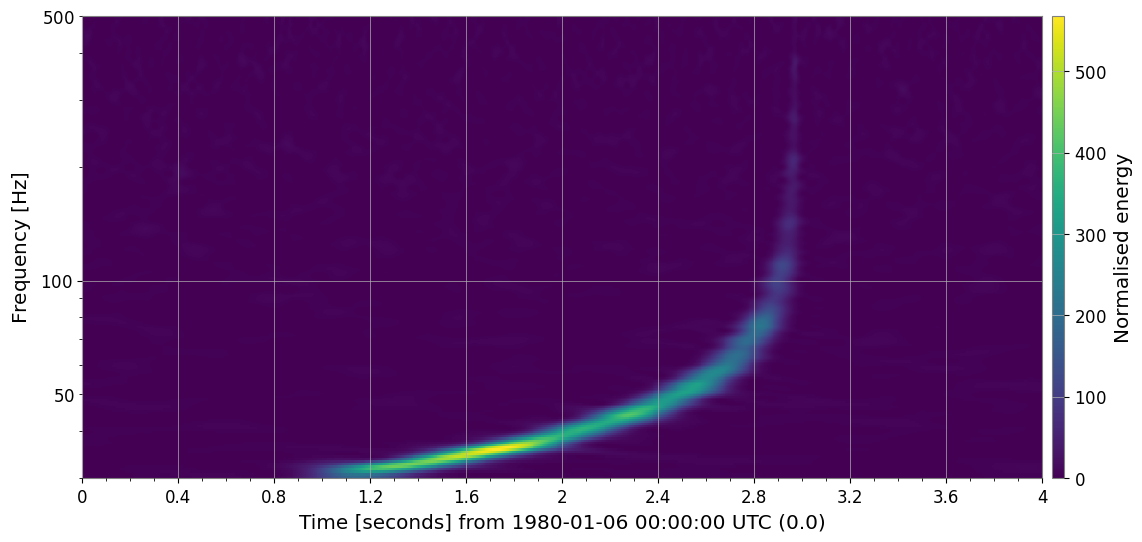

In [9]:
q1 = gwpy_strain.q_transform(frange=(30, 500), qrange=(20, 200),outseg=(0,4))
plot = q1.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

## Question 4: Time of Merger

#### Time of merger as visible in the plot above is at 3.0 seconds after UTC (-64.0), i.e. at **67 seconds** after the run started

# **Set 1**: Challenge 2

In [10]:
pycbc_strain2 = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')
gwpy_strain2 = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")

## Question 1: Time of Merger Estimate Using Q-Transform

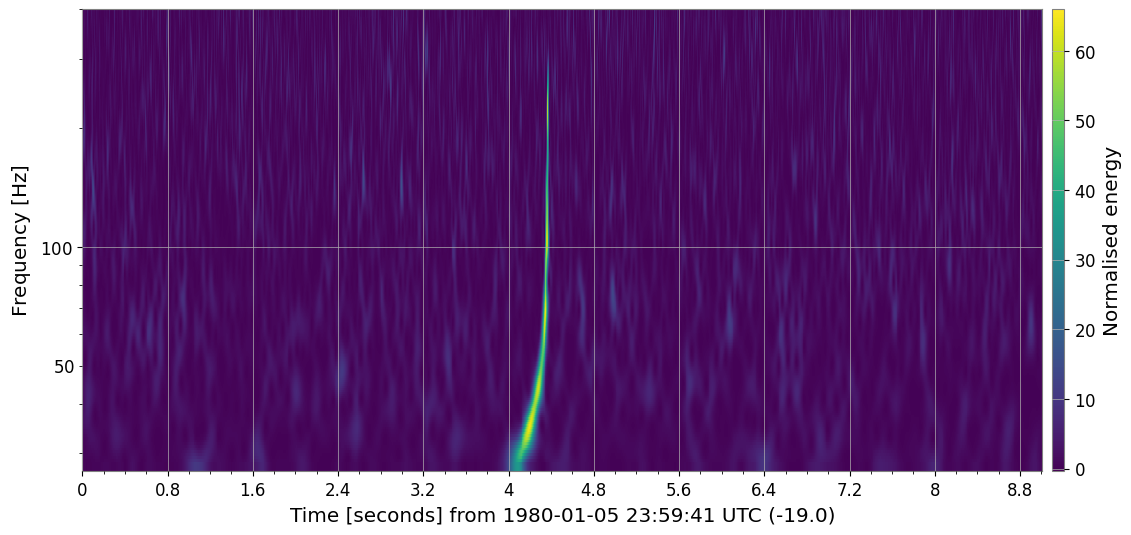

In [11]:
q2 = gwpy_strain2.q_transform(frange=(27, 400), qrange=(10, 100),outseg=(-19,-10))
plot = q2.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

#### Time of merger as visible in the plot above is at 4.4 seconds after UTC (-19.0), i.e. **-14,6** seconds after recording started

## Question 2: Time-Domain Template Waveform Using "SEOBNRv4_opt"

In [12]:
from pycbc.waveform import get_td_waveform
import pylab

In [13]:
sample_rate = pycbc_strain2.get_sample_rate()
print("Sample Rate:",sample_rate)

Sample Rate: 4096.0


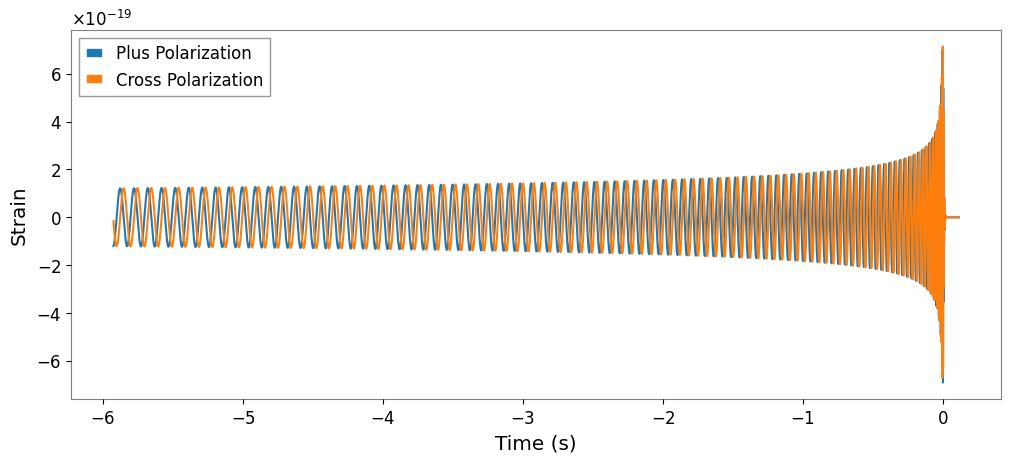

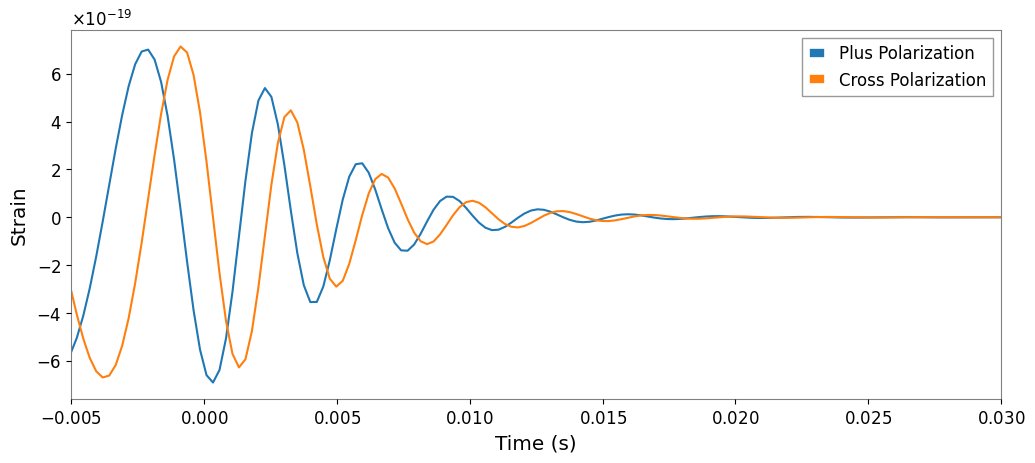

In [14]:
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         delta_t=1.0/sample_rate,
                         f_lower=10)
#spin not included here as it is 0. Moreover, the approximant cannot compute a non-zero spin.


pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time
pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.xlim(-.005, .03)
pylab.legend()
pylab.grid()
pylab.show()

## Question 3: Plot PSD

In [15]:
# nyquist frequency is defined as half the sample rate
nyquist_f = sample_rate/2
print("Nyquist Frequency:",nyquist_f)

Nyquist Frequency: 2048.0


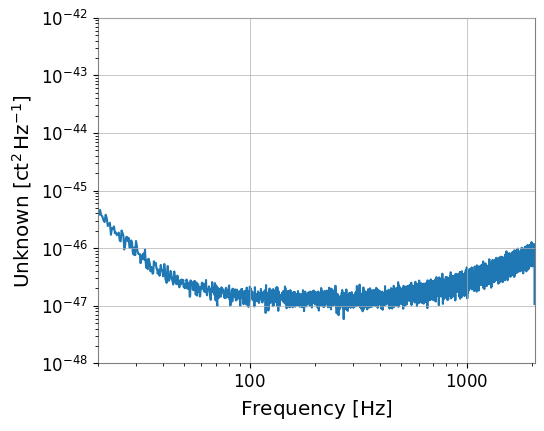

In [16]:
psd = gwpy_strain2.psd(fftlength=4, method="median")
plotpsd = psd.plot()
ax = plotpsd.gca()
ax.set_xlim(20, nyquist_f)
ax.set_xscale("log")
ax.set_ylim(1e-48, 1e-42)
ax.set_yscale("log")

## Question 4: Calculating the SNR time series using PSD and the Template Waveform



#### Data Conditioning

In [17]:
import pylab
from pycbc.filter import resample_to_delta_t, highpass

In [18]:
#apply highpass to remove low-frequency noise
high = highpass(pycbc_strain2, 15.0)

In [19]:
conditioned = high.crop(2, 2)
len(conditioned)

507904

#### Making PSD & Approximant Data Consistent

In [20]:
m = 30 # Solar masses
delta_t = 1.0/sample_rate
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# Resize the vector to match our data
hp.resize(len(conditioned))

template = hp.cyclic_time_shift(hp.start_time)
len(template)

507904

In [21]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

#### Plotting the SNR Time-Series

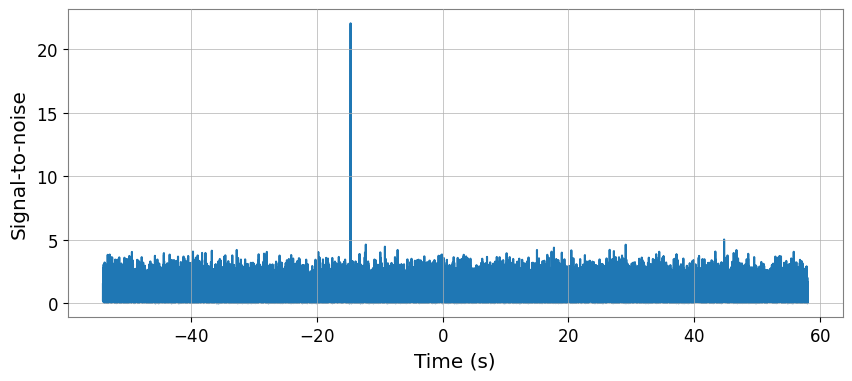

In [22]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template and psd filters: remore 4 seconds from beginning and end of PSD
#and 4 seconds at the end of template

snr = snr.crop(4 + 4, 4)

# taking an abs() to maximise over the phase of the signal
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

### Question 5: Matched Filter SNR of Signal

In [23]:
print("Signal at {}s with SNR {}".format(time,
                                                    abs(snrp)))

Signal at -14.6328125s with SNR 22.055335211212928


# **Set 2**: Challenge 2

## Question 1: Testing For GW signal in Data

#### Loading Data

In [26]:
import numpy as np
import pycbc
from pycbc.types import FrequencySeries, TimeSeries
import matplotlib.pyplot as plt

d = np.load('noise_ts_4096Hz.npy')

time = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = time[1]-
time[0])
data = d


ValueError: cannot reshape array of size 917488 into shape (2,4096000)

#### Convert data to timeseries

In [ ]:
import pycbc.types
dt = time[1] - time[0]
data = pycbc.types.TimeSeries(d[:, 1], delta_t = dt)

#### Calculating and Plotting SNR: Mass = 5

In [ ]:
conditioned = highpass(data, 15.0)
conditioned = conditioned.crop(2, 2)

#approximant
m1 = 5 #lower bound
delta_t = 1.0/sample_rate
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m1,
                     mass2=m1,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

hp.resize(len(conditioned))

template = hp.cyclic_time_shift(hp.start_time)

# PSD
from pycbc.psd import interpolate, inverse_spectrum_truncation
psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

#SNR
snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)


snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

#### Calculating and Plotting SNR: Mass = 10

In [ ]:
conditioned = highpass(data, 15.0)
conditioned = conditioned.crop(2, 2)

#approximant
m2 = 10 #lower bound
delta_t = 1.0/sample_rate
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m2,
                     mass2=m2,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

hp.resize(len(conditioned))

template = hp.cyclic_time_shift(hp.start_time)

# PSD
from pycbc.psd import interpolate, inverse_spectrum_truncation
psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

#SNR
snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)


snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

#### The Signal SNR Values for both Mass = 5 (**no.**) and Mass = 10 (**no.**) are greater that 8, i.e. a gravitational wave signal is present

## Question 2: Whitening Data using noise PSD

In [ ]:
import pycbc.psd



In [ ]:
white_data = (data.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()